### Ćwiczenia projektowe 2.
Anna Marjankowska, Adrian Żyła

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

#### Wczytanie zestawu danych oraz obróbka.

In [2]:
data = pd.read_csv('/Users/aniamarjankowska/Documents/GitHub/machine_learning/decision_tree/stroke_zaj2.csv', sep = ';', decimal = ',')
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [3]:
data.shape

(400, 11)

In [4]:
data['stroke'].value_counts()

1    200
0    200
Name: stroke, dtype: int64

In [5]:
data.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [6]:
data.isnull().sum()

gender                0
age                   0
hypertension          0
heart_disease         0
ever_married          0
work_type             0
Residence_type        0
avg_glucose_level     0
bmi                  37
smoking_status        0
stroke                0
dtype: int64

#### **Zadanie 1.**
**Scharakteryzować krótko wykorzystywane dane (czego dotyczą, jakiego rodzaju zmienne zawierają, jaki jest poziom zbalansowania zbioru danych). Wyeliminować braki danych.**


W zbiorze danych posiadamy zmienne dotyczące **stanu zdrowia**, **stylu życia** oraz **wieku**.  
Zmienne kategoryczne to **gender**, **ever_married**, **work_type**, **residence_type**, **smoking_status**. Pozostałe zmienne, to zmienne ilościowe. <br>
Zbiór danych jest **zbalansowany**, posiadamy $200$ obserwacji należących do klasy pozytywnej, jak i $200$ obserwacji należąych do klasy negatywnej. 
<br>
W danych występują **brakujące wartości** dla zmiennej **BMI**, dlatego zdecydowaliśmy się na ich usunięcie.*  
<br>
**Podczas ćwiczeń przetestowaliśmy modele na dwóch różnych zestawach danych: jednym z usuniętymi brakującymi wartościami oraz drugim, w którym brakujące dane zostały zastąpione średnią. Okazało się, że modele osiągały lepsze wyniki na danych, z których usunięto brakujące wartości.*
 

Przechodzimy więc do usunięcia z danych wierszych, w których brakuje danych dla zmiennej BMI.

In [7]:
data = data.dropna()

In [8]:
data.shape

(363, 11)

In [9]:
data['stroke'].value_counts()

0    193
1    170
Name: stroke, dtype: int64

Po wyeliminownaiu brakujących wartości, rozkład jest w miarę równomierny, około $47\%$ dla klasy pozytywnej i $53\%$ dla klasy negatywnej. Przy takiej różnicy uznajemy dane za wystarczająco zbalansowane.

W następnym kroku zamienimy zmienne kategoryczne na zmienne binarne, za pomocą **one-hot endoding**.

In [10]:
gender_dummies = pd.get_dummies(data['gender'], dtype = int, drop_first = True)
ever_married_dummies = pd.get_dummies(data['ever_married'], dtype = int, drop_first = True)
work_type_dummies = pd.get_dummies(data['work_type'], dtype = int, drop_first = True)
residence_type_dummies = pd.get_dummies(data['Residence_type'], dtype = int, drop_first = True)
smoking_status_dummies = pd.get_dummies(data['smoking_status'], dtype = int, drop_first = True)

In [11]:
data = pd.concat([gender_dummies, data[['age', 'hypertension', 'heart_disease']], ever_married_dummies, work_type_dummies, 
        residence_type_dummies, data[['avg_glucose_level', 'bmi',]], smoking_status_dummies, data[['stroke']]], axis = 1)
data = data.rename(columns = {'Yes': 'ever_married'})
data.head()

,Male,age,hypertension,heart_disease,ever_married,Never_worked,Private,Self-employed,children,Urban,avg_glucose_level,bmi,formerly smoked,never smoked,smokes,stroke
0,1,67.0,0,1,1,0,1,0,0,1,228.69,36.6,1,0,0,1
1,1,80.0,0,1,1,0,1,0,0,0,105.92,32.5,0,1,0,1
2,0,49.0,0,0,1,0,1,0,0,1,171.23,34.4,0,0,1,1
3,0,79.0,1,0,1,0,0,1,0,0,174.12,24.0,0,1,0,1
4,1,81.0,0,0,1,0,1,0,0,1,186.21,29.0,1,0,0,1


#### Budowa modelu - drzewa decyzyjne.

#### **Zadanie 2.**
**Wykorzystać proste drzewo decyzyjne do predykcji wartości zmiennej wynikowej. Zweryfikować jak poziom przycięcie drzewa wpływa na uzyskiwane wyniki (zarówno na zbiorze testowym, jak i uczącym). Zwrócić szczególną uwagę na miary: dokładności, czułości i specyficzności.**

Podział danych na zbiór uczący i testowy w proporcji $70/30$:

In [12]:
y = data.stroke
X = data.iloc[:, 0:14]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Budowa modelu drzewa decyzyjnego z domyślnymi parametrami:

In [13]:
model_dc = DecisionTreeClassifier()
model_dc.fit(X_train, y_train)

y_pred_train = model_dc.predict(X_train)
y_pred_test = model_dc.predict(X_test)

Prezentacja wyników na zbiorze uczącym:


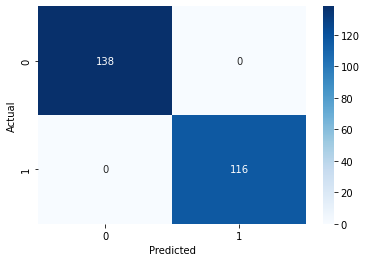

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00       116

    accuracy                           1.00       254
   macro avg       1.00      1.00      1.00       254
weighted avg       1.00      1.00      1.00       254

Dokładność modelu: 1.00
Czułość modelu: 1.00


In [14]:
print("Prezentacja wyników na zbiorze uczącym:")
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_train, y_pred_train))
print(f"Dokładność modelu: {accuracy_score(y_train, y_pred_train):0.2f}")
print(f"Czułość modelu: {recall_score(y_train, y_pred_train):0.2f}")

Prezentacja wyników na zbiorze testowym:


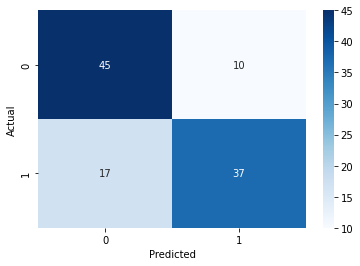

              precision    recall  f1-score   support

           0       0.73      0.82      0.77        55
           1       0.79      0.69      0.73        54

    accuracy                           0.75       109
   macro avg       0.76      0.75      0.75       109
weighted avg       0.76      0.75      0.75       109

Dokładność modelu: 0.75
Czułość modelu: 0.69


In [15]:
print("Prezentacja wyników na zbiorze testowym:")
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_test, y_pred_test))
print(f"Dokładność modelu: {accuracy_score(y_test, y_pred_test):0.2f}")
print(f"Czułość modelu: {recall_score(y_test, y_pred_test):0.2f}")

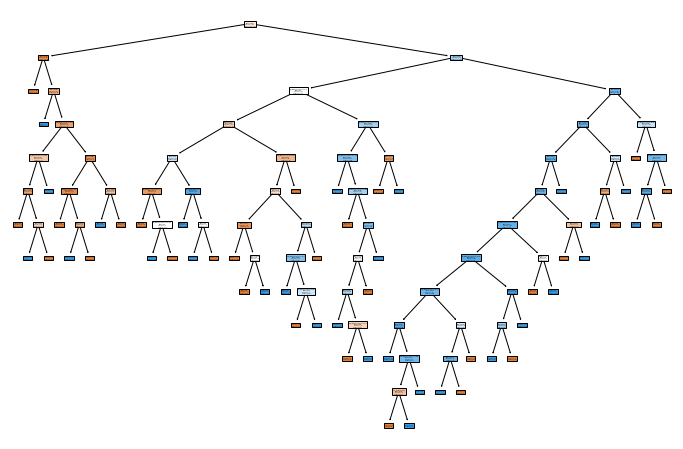

In [17]:
plt.figure(figsize=(12, 8))
plot_tree(model_dc, feature_names=X_train.columns, filled=True)
plt.show()

Na zbiorze uczącym otrzymaliśmy dokładność na poziomie $100\%$, natomiast na zbiorze testowym dokładność jest na poziomie około $71\%$. Może to świadczyć o nadmiernym **przeuczeniu modelu**.<br>
Na wizualizacji widzimy, że drzewo jest bardzo głębokie i szczegółowe, w efekcie czego może nadmiernie dopasowywać się do danych treningowych.

Zobaczmy teraz jak zadziała ustawienie parametrów - **max_depth** oraz **criterion**.

In [23]:
model_dc2 = DecisionTreeClassifier(max_depth=3, criterion='gini' )
model_dc2.fit(X_train, y_train)

y_pred_train = model_dc2.predict(X_train)
y_pred_test = model_dc2.predict(X_test)

Prezentacja wyników na zbiorze uczącym:


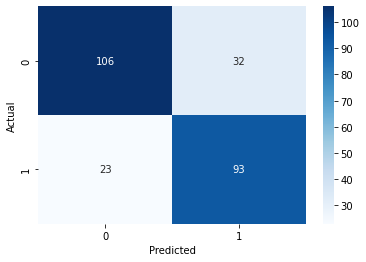

              precision    recall  f1-score   support

           0       0.82      0.77      0.79       138
           1       0.74      0.80      0.77       116

    accuracy                           0.78       254
   macro avg       0.78      0.78      0.78       254
weighted avg       0.79      0.78      0.78       254

Dokładność modelu: 0.78
Czułość modelu: 0.80


In [24]:
print("Prezentacja wyników na zbiorze uczącym:")
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_train, y_pred_train))
print(f"Dokładność modelu: {accuracy_score(y_train, y_pred_train):0.2f}")
print(f"Czułość modelu: {recall_score(y_train, y_pred_train):0.2f}")

Prezentacja wyników na zbiorze testowym:


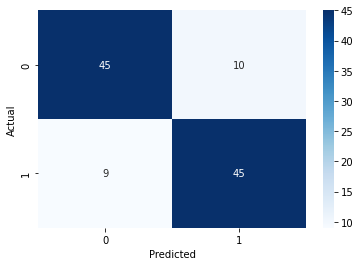

              precision    recall  f1-score   support

           0       0.83      0.82      0.83        55
           1       0.82      0.83      0.83        54

    accuracy                           0.83       109
   macro avg       0.83      0.83      0.83       109
weighted avg       0.83      0.83      0.83       109

Dokładność modelu: 0.83
Czułość modelu: 0.83


In [25]:
print("Prezentacja wyników na zbiorze testowym:")
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_test, y_pred_test))
print(f"Dokładność modelu: {accuracy_score(y_test, y_pred_test):0.2f}")
print(f"Czułość modelu: {recall_score(y_test, y_pred_test):0.2f}")

Po ustawieniu parametrów uzyskaliśmy dokładność na poziomie $73\%$ na zbiorze uczącym oraz $81\%$ na zbiorze testowym, co może wskazywać, że model nie jest przeuczony i dobrze radzi sobie z klasyfikacją wcześniej niewidzianych danych.<br>
Na zwrócenie uwagi zasługuje również **czułośc modelu**, która, na zbiorze testowym, jest na poziomie $93\%$, co jest szczególnie istotne przy predykcji chorób. 

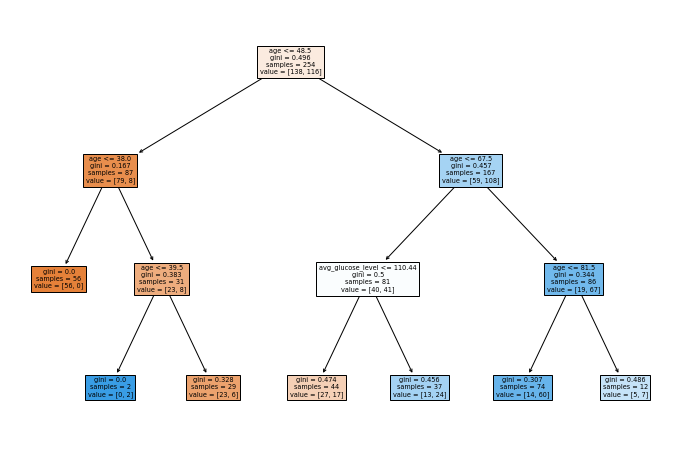

In [26]:
plt.figure(figsize=(12, 8))
plot_tree(model_dc2, feature_names=X_train.columns, filled=True)
plt.show()

Z wizualizacji drzewa, widzimy, zmienna **wiek** występuje na pierwszym poziomie drzewa (główne rozgałęzienie), co wskazuje, że jest kluczowym czynnikiem wpływającym na podział danych. 

#### **Zadanie 3.** 
**Zastosować 2 z 3 możliwych rozszerzeń drzew decyzyjnych: las losowy, bagging, boosting. Zweryfikować, jak dobór hiperparametrów wpływa na wyniki. W przypadku rozszerzeń przeanalizować można np. zmiany:**
- **bagging: liczby drzew, liczby obserwacji, złożoności drzewa,**
- **las losowy: liczby drzew w lesie, liczby zmiennych, złożoności drzewa,**
- **boosting: liczby modeli do zbudowania.**

**Porównać wyniki z zadania 2 i 3.**



#### Budowa modelu - las losowy. 

In [28]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

y_pred_train = model_rf.predict(X_train)
y_pred_test = model_rf.predict(X_test)

Prezentacja wyników na zbiorze uczącym:


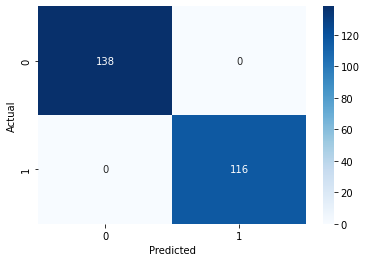

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00       116

    accuracy                           1.00       254
   macro avg       1.00      1.00      1.00       254
weighted avg       1.00      1.00      1.00       254

Dokładność modelu: 1.00
Czułość modelu: 1.00


In [29]:
print("Prezentacja wyników na zbiorze uczącym:")
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_train, y_pred_train))
print(f"Dokładność modelu: {accuracy_score(y_train, y_pred_train):0.2f}")
print(f"Czułość modelu: {recall_score(y_train, y_pred_train):0.2f}")

Prezentacja wyników na zbiorze testowym:


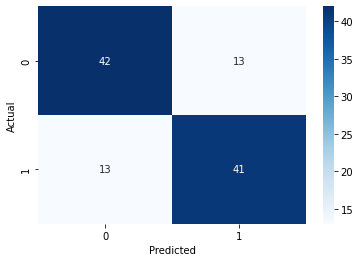

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        55
           1       0.76      0.76      0.76        54

    accuracy                           0.76       109
   macro avg       0.76      0.76      0.76       109
weighted avg       0.76      0.76      0.76       109

Dokładność modelu: 0.76
Czułość modelu: 0.76


In [30]:
print("Prezentacja wyników na zbiorze testowym:")
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_test, y_pred_test))
print(f"Dokładność modelu: {accuracy_score(y_test, y_pred_test):0.2f}")
print(f"Czułość modelu: {recall_score(y_test, y_pred_test):0.2f}")

In [31]:
model_rf2 = RandomForestClassifier(max_depth = 3, n_estimators = 25, criterion='gini')
model_rf2.fit(X_train, y_train)

y_pred_train = model_rf2.predict(X_train)
y_pred_test = model_rf2.predict(X_test)

Prezentacja wyników na zbiorze uczącym:


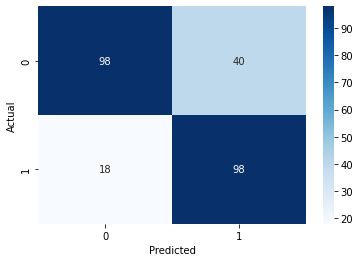

              precision    recall  f1-score   support

           0       0.84      0.71      0.77       138
           1       0.71      0.84      0.77       116

    accuracy                           0.77       254
   macro avg       0.78      0.78      0.77       254
weighted avg       0.78      0.77      0.77       254

Dokładność modelu: 0.77
Czułość modelu: 0.84


In [32]:
print("Prezentacja wyników na zbiorze uczącym:")
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_train, y_pred_train))
print(f"Dokładność modelu: {accuracy_score(y_train, y_pred_train):0.2f}")
print(f"Czułość modelu: {recall_score(y_train, y_pred_train):0.2f}")

Prezentacja wyników na zbiorze testowym:


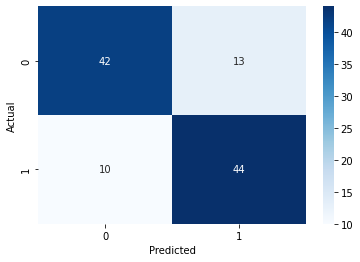

              precision    recall  f1-score   support

           0       0.81      0.76      0.79        55
           1       0.77      0.81      0.79        54

    accuracy                           0.79       109
   macro avg       0.79      0.79      0.79       109
weighted avg       0.79      0.79      0.79       109

Dokładność modelu: 0.79
Czułość modelu: 0.81


In [33]:
print("Prezentacja wyników na zbiorze testowym:")
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_test, y_pred_test))
print(f"Dokładność modelu: {accuracy_score(y_test, y_pred_test):0.2f}")
print(f"Czułość modelu: {recall_score(y_test, y_pred_test):0.2f}")

In [62]:
best_n_estimators = 0
best_max_depth = 0
best_accuracy = 0
for i in tqdm(range(1, 50)):
    for j in range(1, 20):
        model_rf = RandomForestClassifier(n_estimators=i, max_depth=j, random_state=42)
        model_rf.fit(X_train, y_train)
        y_pred_test = model_rf.predict(X_test)
        accuracy_test = accuracy_score(y_test, y_pred_test)
        if accuracy_test > best_accuracy:
            best_accuracy = accuracy_test
            best_n_estimators = i
            best_max_depth = j

100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


In [63]:
print(f'Najlepsza liczba n_estimators: {best_n_estimators}')
print(f'Najlepsza wartość max_depth: {best_max_depth}')
print(f'Największa dokładność na zbiorze testowym: {best_accuracy:0.2f}')

Najlepsza liczba n_estimators: 9
Najlepsza wartość max_depth: 12
Największa dokładność na zbiorze testowym: 0.83


In [67]:
model_rf2 = RandomForestClassifier(max_depth=9, n_estimators=12, random_state=42)
model_rf2.fit(X_train, y_train)

y_pred_train = model_rf2.predict(X_train)
y_pred_test = model_rf2.predict(X_test)

Prezentacja wyników na zbiorze uczącym:


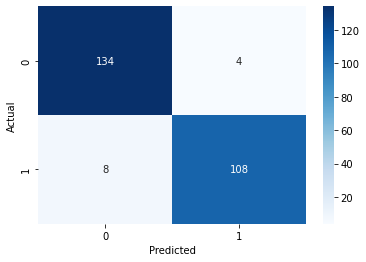

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       138
           1       0.96      0.93      0.95       116

    accuracy                           0.95       254
   macro avg       0.95      0.95      0.95       254
weighted avg       0.95      0.95      0.95       254

Dokładność modelu: 0.95
Czułość modelu: 0.93


In [68]:
print("Prezentacja wyników na zbiorze uczącym:")
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_train, y_pred_train))
print(f"Dokładność modelu: {accuracy_score(y_train, y_pred_train):0.2f}")
print(f"Czułość modelu: {recall_score(y_train, y_pred_train):0.2f}")

Prezentacja wyników na zbiorze testowym:


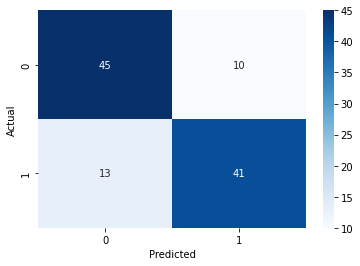

              precision    recall  f1-score   support

           0       0.78      0.82      0.80        55
           1       0.80      0.76      0.78        54

    accuracy                           0.79       109
   macro avg       0.79      0.79      0.79       109
weighted avg       0.79      0.79      0.79       109

Dokładność modelu: 0.79
Czułość modelu: 0.76


In [69]:
print("Prezentacja wyników na zbiorze testowym:")
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_test, y_pred_test))
print(f"Dokładność modelu: {accuracy_score(y_test, y_pred_test):0.2f}")
print(f"Czułość modelu: {recall_score(y_test, y_pred_test):0.2f}")

#### Budowa modelu - AdaBoost.

In [86]:
model_ab = AdaBoostClassifier()
model_ab.fit(X_train, y_train)

y_pred_train = model_ab.predict(X_train)
y_pred_test = model_ab.predict(X_test)

Prezentacja wyników na zbiorze uczącym:


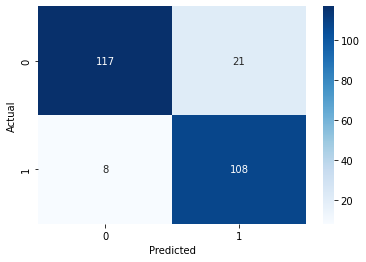

              precision    recall  f1-score   support

           0       0.94      0.85      0.89       138
           1       0.84      0.93      0.88       116

    accuracy                           0.89       254
   macro avg       0.89      0.89      0.89       254
weighted avg       0.89      0.89      0.89       254

Dokładność modelu: 0.89
Czułość modelu: 0.93


In [87]:
print("Prezentacja wyników na zbiorze uczącym:")
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_train, y_pred_train))
print(f"Dokładność modelu: {accuracy_score(y_train, y_pred_train):0.2f}")
print(f"Czułość modelu: {recall_score(y_train, y_pred_train):0.2f}")

Prezentacja wyników na zbiorze testowym:


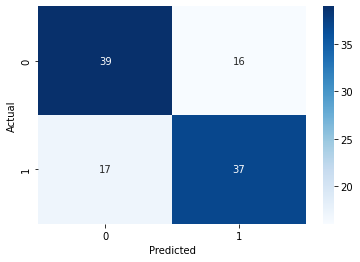

              precision    recall  f1-score   support

           0       0.70      0.71      0.70        55
           1       0.70      0.69      0.69        54

    accuracy                           0.70       109
   macro avg       0.70      0.70      0.70       109
weighted avg       0.70      0.70      0.70       109

Dokładność modelu: 0.70
Czułość modelu: 0.69


In [88]:
print("Prezentacja wyników na zbiorze testowym:")
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_test, y_pred_test))
print(f"Dokładność modelu: {accuracy_score(y_test, y_pred_test):0.2f}")
print(f"Czułość modelu: {recall_score(y_test, y_pred_test):0.2f}")

#### Budowa modelu - bagging.

In [90]:
model_bagg = BaggingClassifier()
model_bagg.fit(X_train, y_train)

y_pred_train = model_bagg.predict(X_train)
y_pred_test = model_bagg.predict(X_test)

Prezentacja wyników na zbiorze uczącym:


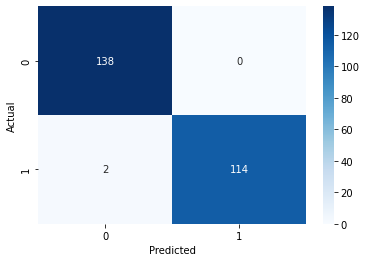

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       138
           1       1.00      0.98      0.99       116

    accuracy                           0.99       254
   macro avg       0.99      0.99      0.99       254
weighted avg       0.99      0.99      0.99       254

Dokładność modelu: 0.99
Czułość modelu: 0.98


In [91]:
print("Prezentacja wyników na zbiorze uczącym:")
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_train, y_pred_train))
print(f"Dokładność modelu: {accuracy_score(y_train, y_pred_train):0.2f}")
print(f"Czułość modelu: {recall_score(y_train, y_pred_train):0.2f}")

Prezentacja wyników na zbiorze testowym:


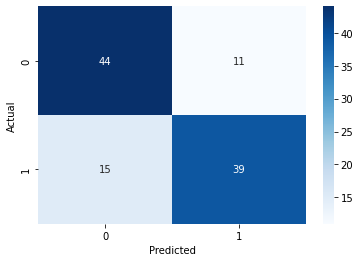

              precision    recall  f1-score   support

           0       0.75      0.80      0.77        55
           1       0.78      0.72      0.75        54

    accuracy                           0.76       109
   macro avg       0.76      0.76      0.76       109
weighted avg       0.76      0.76      0.76       109

Dokładność modelu: 0.76
Czułość modelu: 0.72


In [92]:
print("Prezentacja wyników na zbiorze testowym:")
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_test, y_pred_test))
print(f"Dokładność modelu: {accuracy_score(y_test, y_pred_test):0.2f}")
print(f"Czułość modelu: {recall_score(y_test, y_pred_test):0.2f}")

#### **Zadanie 4.** 
**Wykorzystać algorytm SVM do predykcji wartości zmiennej wynikowej (UWAGA: w metodzie tej zalecana jest standaryzacja danych). Zbudować modele wykorzystujące:**
- **jądro liniowe (linear),**
- **jądro wielomianowe (poly),**
- **jądro radialne (rbf - radial basis function).**

**W każdym przypadku przyjąć domyśle wartości pozostałych hiperparametrów. Zinterpretować wyniki.**

#### Budowa modelu - SVM.

Do algorytmu SVM wskazane jest przeprowadzenie standaryzacji danych. Tak jak w przypadku drzew, usuniemy wiersze zawierające braki zmiennej **BMI** oraz zamienimy zmienne kategoryczne na zmienne binarne.

In [101]:
data = pd.read_csv('/Users/aniamarjankowska/Documents/GitHub/machine_learning/decision_tree/stroke_zaj2.csv', sep = ';', decimal = ',')
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [102]:
data = data.dropna()

In [103]:
gender_dummies = pd.get_dummies(data['gender'], dtype = int, drop_first = True) # Ustawiamy zmienna drop_first na True, aby pominac jedna kolumnę, w celu uniknięcia wspólniowości zmiennych
ever_married_dummies = pd.get_dummies(data['ever_married'], dtype = int, drop_first = True)
work_type_dummies = pd.get_dummies(data['work_type'], dtype = int, drop_first = True)
residence_type_dummies = pd.get_dummies(data['Residence_type'], dtype = int, drop_first = True)
smoking_status_dummies = pd.get_dummies(data['smoking_status'], dtype = int, drop_first = True)

In [104]:
data = pd.concat([gender_dummies, data[['age', 'hypertension', 'heart_disease']], ever_married_dummies, work_type_dummies, 
        residence_type_dummies, data[['avg_glucose_level', 'bmi',]], smoking_status_dummies, data[['stroke']]], axis = 1)
data = data.rename(columns = {'Yes': 'ever_married'})
data.head()

,Male,age,hypertension,heart_disease,ever_married,Never_worked,Private,Self-employed,children,Urban,avg_glucose_level,bmi,formerly smoked,never smoked,smokes,stroke
0,1,67.0,0,1,1,0,1,0,0,1,228.69,36.6,1,0,0,1
1,1,80.0,0,1,1,0,1,0,0,0,105.92,32.5,0,1,0,1
2,0,49.0,0,0,1,0,1,0,0,1,171.23,34.4,0,0,1,1
3,0,79.0,1,0,1,0,0,1,0,0,174.12,24.0,0,1,0,1
4,1,81.0,0,0,1,0,1,0,0,1,186.21,29.0,1,0,0,1


Podział na zbiór uczący oraz testowy:

In [105]:
X = data.iloc[:, 0:14]
y = data.stroke
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Standaryzacja danych, aby model był mniej obciążony obliczeniowo:

In [106]:
scaler = StandardScaler()
X_train[['age', 'avg_glucose_level', 'bmi']] = scaler.fit_transform(X_train[['age', 'avg_glucose_level', 'bmi']])
X_test[['age', 'avg_glucose_level', 'bmi']] = scaler.transform(X_test[['age', 'avg_glucose_level', 'bmi']])

SVM - linear kernel, budowa modelu:

In [107]:
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, y_train)

y_pred_train = svm_linear.predict(X_train)
y_pred_test = svm_linear.predict(X_test)

Prezentacja wyników na zbiorze uczącym:


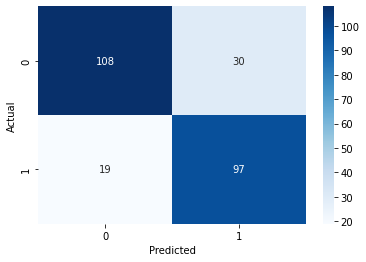

              precision    recall  f1-score   support

           0       0.85      0.78      0.82       138
           1       0.76      0.84      0.80       116

    accuracy                           0.81       254
   macro avg       0.81      0.81      0.81       254
weighted avg       0.81      0.81      0.81       254

Dokładność modelu: 0.81
Czułość modelu: 0.84


In [108]:
print("Prezentacja wyników na zbiorze uczącym:")
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_train, y_pred_train))
print(f"Dokładność modelu: {accuracy_score(y_train, y_pred_train):0.2f}")
print(f"Czułość modelu: {recall_score(y_train, y_pred_train):0.2f}")

Prezentacja wyników na zbiorze testowym:


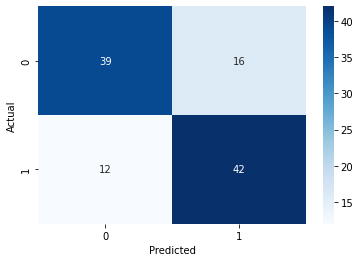

              precision    recall  f1-score   support

           0       0.76      0.71      0.74        55
           1       0.72      0.78      0.75        54

    accuracy                           0.74       109
   macro avg       0.74      0.74      0.74       109
weighted avg       0.74      0.74      0.74       109

Dokładność modelu: 0.74
Czułość modelu: 0.78


In [109]:
print("Prezentacja wyników na zbiorze testowym:")
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_test, y_pred_test))
print(f"Dokładność modelu: {accuracy_score(y_test, y_pred_test):0.2f}")
print(f"Czułość modelu: {recall_score(y_test, y_pred_test):0.2f}")

SVM - poly kernel, budowa modelu:

In [113]:
svm_poly = SVC(kernel='poly')
svm_poly.fit(X_train, y_train)

y_pred_train = svm_poly.predict(X_train)
y_pred_test = svm_poly.predict(X_test)

Prezentacja wyników na zbiorze uczącym:


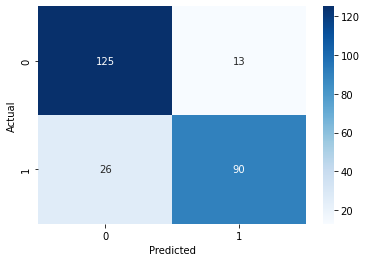

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       138
           1       0.87      0.78      0.82       116

    accuracy                           0.85       254
   macro avg       0.85      0.84      0.84       254
weighted avg       0.85      0.85      0.85       254

Dokładność modelu: 0.85
Czułość modelu: 0.78


In [114]:
print("Prezentacja wyników na zbiorze uczącym:")
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_train, y_pred_train))
print(f"Dokładność modelu: {accuracy_score(y_train, y_pred_train):0.2f}")
print(f"Czułość modelu: {recall_score(y_train, y_pred_train):0.2f}")

Prezentacja wyników na zbiorze testowym:


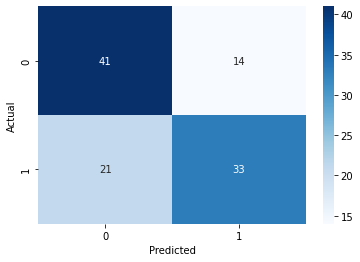

              precision    recall  f1-score   support

           0       0.66      0.75      0.70        55
           1       0.70      0.61      0.65        54

    accuracy                           0.68       109
   macro avg       0.68      0.68      0.68       109
weighted avg       0.68      0.68      0.68       109

Dokładność modelu: 0.68
Czułość modelu: 0.61


In [115]:
print("Prezentacja wyników na zbiorze testowym:")
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_test, y_pred_test))
print(f"Dokładność modelu: {accuracy_score(y_test, y_pred_test):0.2f}")
print(f"Czułość modelu: {recall_score(y_test, y_pred_test):0.2f}")

SVM - RBF kernel, budowa modelu:

In [117]:
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)

y_pred_train = svm_rbf.predict(X_train)
y_pred_test = svm_rbf.predict(X_test)

Prezentacja wyników na zbiorze uczącym:


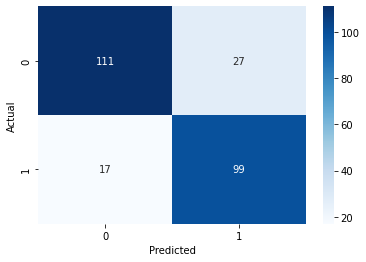

              precision    recall  f1-score   support

           0       0.87      0.80      0.83       138
           1       0.79      0.85      0.82       116

    accuracy                           0.83       254
   macro avg       0.83      0.83      0.83       254
weighted avg       0.83      0.83      0.83       254

Dokładność modelu: 0.83
Czułość modelu: 0.85


In [118]:
print("Prezentacja wyników na zbiorze uczącym:")
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_train, y_pred_train))
print(f"Dokładność modelu: {accuracy_score(y_train, y_pred_train):0.2f}")
print(f"Czułość modelu: {recall_score(y_train, y_pred_train):0.2f}")

Prezentacja wyników na zbiorze testowym:


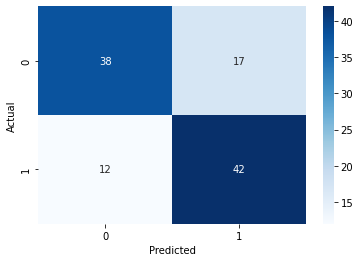

              precision    recall  f1-score   support

           0       0.76      0.69      0.72        55
           1       0.71      0.78      0.74        54

    accuracy                           0.73       109
   macro avg       0.74      0.73      0.73       109
weighted avg       0.74      0.73      0.73       109

Dokładność modelu: 0.73
Czułość modelu: 0.78


In [119]:
print("Prezentacja wyników na zbiorze testowym:")
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_test, y_pred_test))
print(f"Dokładność modelu: {accuracy_score(y_test, y_pred_test):0.2f}")
print(f"Czułość modelu: {recall_score(y_test, y_pred_test):0.2f}")

In [ ]:
kernels = ['linear', 'poly', 'rbf']
results = []
for kernel in kernels:
    model_SVM = SVC(kernel=kernel)
    model_SVM.fit(X_train, y_train)
    y_pred_train = model_SVM.predict(X_train)
    y_pred_test = model_SVM.predict(X_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    results.append([accuracy_train, accuracy_test])
results = pd.DataFrame(results, index=kernels, columns=['accuracy_train', 'accuracy_test'])
results

,accuracy_train,accuracy_test
linear,0.807087,0.743119
poly,0.846457,0.678899
rbf,0.826772,0.733945


In [150]:
model_svm2 = SVC(C=1, degree=1, kernel='linear')
model_svm2.fit(X_train, y_train)

y_pred_train = model_svm2.predict(X_train)
y_pred_test = model_svm2.predict(X_test)

Prezentacja wyników na zbiorze uczącym:


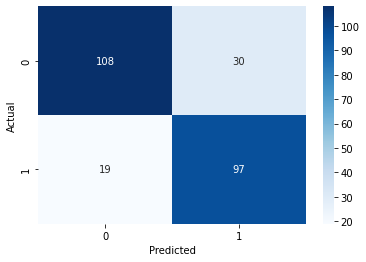

              precision    recall  f1-score   support

           0       0.85      0.78      0.82       138
           1       0.76      0.84      0.80       116

    accuracy                           0.81       254
   macro avg       0.81      0.81      0.81       254
weighted avg       0.81      0.81      0.81       254

Dokładność modelu: 0.81
Czułość modelu: 0.84


In [151]:
print("Prezentacja wyników na zbiorze uczącym:")
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_train, y_pred_train))
print(f"Dokładność modelu: {accuracy_score(y_train, y_pred_train):0.2f}")
print(f"Czułość modelu: {recall_score(y_train, y_pred_train):0.2f}")

Prezentacja wyników na zbiorze testowym:


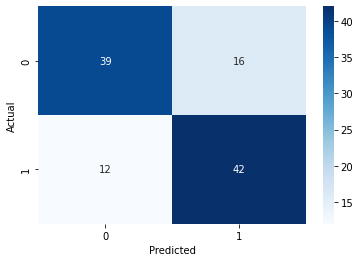

              precision    recall  f1-score   support

           0       0.76      0.71      0.74        55
           1       0.72      0.78      0.75        54

    accuracy                           0.74       109
   macro avg       0.74      0.74      0.74       109
weighted avg       0.74      0.74      0.74       109

Dokładność modelu: 0.74
Czułość modelu: 0.78


In [152]:
print("Prezentacja wyników na zbiorze testowym:")
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_test, y_pred_test))
print(f"Dokładność modelu: {accuracy_score(y_test, y_pred_test):0.2f}")
print(f"Czułość modelu: {recall_score(y_test, y_pred_test):0.2f}")